In [1]:
import pandas as pd
import geopandas as gpd
import requests

In [2]:
# 2020年10月の人口データを取得
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
     'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000020201',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':'A1101',
     # 'cdAreaFrom': From,
     # 'cdAreaTo': To,
     # 'lvCat02':'4-',
     'cdTime':'2020100000',
     }

res = requests.get(URL,p)
text = res.json()
df_pop = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])

print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])

項目名： Ａ　人口・世帯
ヒット件数： 1917


In [3]:
# 2020年10月の面積データを取得
URL = 'http://api.e-stat.go.jp/rest/3.0/app/json/getStatsData'
p = {
     'appId':'6f812f8eb28dc679954f0eef1472fca422edc08d',
     'lang':'J',
     'statsDataId':'0000020202',
     # 'metaGetFlg':'N',
     'explanationGetFlg':'N',
     'annotationGetFlg':'N',
     'cdCat01':','.join(['B1101']),
     # 'cdAreaFrom': From,
     # 'cdAreaTo': To,
     # 'lvCat02':'4-',
     'cdTime':'2020100000',
     }

res = requests.get(URL,p)
text = res.json()
df_area = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['DATA_INF']['VALUE'])
df_code = pd.DataFrame(text['GET_STATS_DATA']['STATISTICAL_DATA']['CLASS_INF']['CLASS_OBJ'][2]['CLASS'])
print('項目名：',text['GET_STATS_DATA']['STATISTICAL_DATA']['TABLE_INF']['TITLE']['$'])
print('ヒット件数：',text['GET_STATS_DATA']['STATISTICAL_DATA']['RESULT_INF']['TOTAL_NUMBER'])

項目名： Ｂ　自然環境
ヒット件数： 1917


In [4]:
# 人口密度が40人/km2以上で、市区町村コードが11000以上15000未満の市区町村を抽出
list_code = df_code['@parentCode'].to_list()
df_pop = pd.merge(df_pop,df_code[['@code','@name']],left_on='@area',right_on='@code')
df_did = pd.merge(df_pop,df_area,on='@area',suffixes=('_pop','_area'))[['@area','@name','$_pop','$_area']]
df_did.columns = ['jcode','名前','人口','面積']
df_did['人口'] = df_did['人口'].astype(int)
df_did['面積'] = df_did['面積'].astype(int)
df_did['人口密度'] = df_did['人口'] / df_did['面積']
df_did = df_did[df_did['jcode'].str[:2].isin(['08', '11', '12', '13', '14'])]
df_did = df_did.query('(人口密度 > 40 | jcode in ["11234","11237","12220","12217","08224","08235","08220"])& jcode not in @list_code')

list_did = df_did['jcode'].to_list()

In [7]:
df_did

,jcode,名前,人口,面積,人口密度
436,08220,茨城県 つくば市,241656,28372,8.517412
440,08224,茨城県 守谷市,68421,3571,19.160179
451,08235,茨城県 つくばみらい市,49872,7916,6.300152
527,11102,埼玉県 さいたま市 北区,149242,1686,88.518387
528,11103,埼玉県 さいたま市 大宮区,117784,1280,92.018750
...,...,...,...,...,...
755,14205,神奈川県 藤沢市,436905,6956,62.809804
757,14207,神奈川県 茅ヶ崎市,242389,3570,67.896078
762,14213,神奈川県 大和市,239169,2709,88.286822
764,14215,神奈川県 海老名市,136516,2659,51.341106


In [13]:
# 2000~2020までの廃置分合データの読み込み
df_2000 = pd.read_csv('data/setup_2000_2020/FEA_haitibungou-20241231125108.csv',dtype={0:str})
df_2000['DID'] = df_2000['標準地域コード'].apply(lambda x: True if x in list_did else False)
df_2000 = df_2000.query('DID | 標準地域コード in ["11244","14209","14150"]')
df_2000.to_csv('data/setup_2000_2020/haitibungou.csv',index=False)

In [14]:
df_2000

,標準地域コード,都道府県,政令市･郡･支庁･振興局等,政令市･郡･支庁･振興局等（ふりがな）,市区町村,市区町村（ふりがな）,廃置分合等施行年月日,改正事由,DID
5,08224,茨城県,NaN,NaN,守谷市,もりやし,2002-02-02,守谷町(08561)が守谷市(08224)に市制施行,True
16,08235,茨城県,NaN,NaN,つくばみらい市,つくばみらいし,2006-03-27,伊奈町(08482)、谷和原村(08483)が合併し、つくばみらい市(08235)を新設\r...,True
21,11102,埼玉県,さいたま市,さいたまし,北区,きたく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
22,11103,埼玉県,さいたま市,さいたまし,大宮区,おおみやく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
23,11104,埼玉県,さいたま市,さいたまし,見沼区,みぬまく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
24,11105,埼玉県,さいたま市,さいたまし,中央区,ちゅうおうく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
25,11106,埼玉県,さいたま市,さいたまし,桜区,さくらく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
26,11107,埼玉県,さいたま市,さいたまし,浦和区,うらわく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
27,11108,埼玉県,さいたま市,さいたまし,南区,みなみく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True
28,11109,埼玉県,さいたま市,さいたまし,緑区,みどりく,2003-04-01,さいたま市(11244)のさいたま市(11100)への政令指定都市施行\r\n西区(1110...,True


In [16]:
#　分析対象のコードを定義
list_jcode = list((set(list_did) - set(df_2000['標準地域コード'].to_list())) | set(["08224","08235","11204","11205","11220","11245","13229","14209"]))
df_jcode = pd.DataFrame(list_jcode,columns=['jcode'])
df_jcode = df_jcode.sort_values('jcode')

# GCIの読み込み
df_gci = pd.read_csv('data/setup_2000_2020/code_gci.csv',header=None,names=['jcode','gci'],dtype={0:str,1:str})
df_jcode = pd.merge(df_jcode,df_gci,on='jcode',how='left')

def get_geom(gci):
    # print(gci)
    pref = gci[:2]
    try: 
        URL = f'https://geoshape.ex.nii.ac.jp/city/topojson/20001001/{pref}/{gci}.topojson'
        gdf = gpd.read_file(URL)
    except: 
        URL = f'https://geoshape.ex.nii.ac.jp/city/topojson/20200101/{pref}/{gci}.topojson'
        gdf = gpd.read_file(URL)
    return gdf.iloc[0,:]

df_jcode = df_jcode.join(df_jcode['gci'].apply(lambda x: get_geom(x)))

<Axes: >

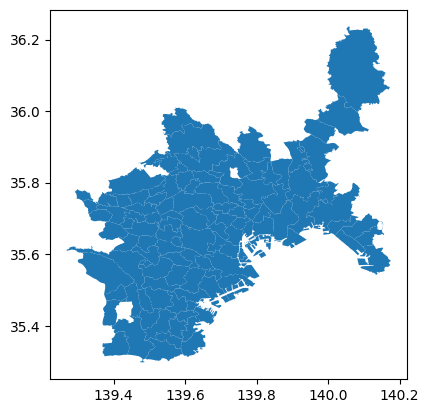

In [17]:
# 結合先Jcodeデータを作成
df_jcode = df_jcode.drop(columns=['gci','id','N03_002','N03_005','N03_006','N03_007'])
df_jcode = gpd.GeoDataFrame(df_jcode,geometry='geometry')
df_jcode.to_file('data/setup_2000_2020/jcode.geojson',driver='GeoJSON')
df_jcode.plot()

In [31]:
#　各年のjcodeの対応表を作成
df_2000 = pd.concat([
    pd.DataFrame({
        'jcode_from':list(set(list_jcode) - set(['08224','08235','11204','11205','11220','11245','13229','14209'])),
        'jcode_to'  :list(set(list_jcode) - set(['08224','08235','11204','11205','11220','11245','13229','14209'])),
    }),
    pd.DataFrame({
        'jcode_from':['08561','08482','11204','11205','11220','11236','11322','13216','13217','14209'],
        'jcode_to'  :['08224','08235','11204','11205','11220','11245','11245','13229','13229','14209'],
    })    
],axis=0).sort_values('jcode_from')
df_2000_info = pd.read_csv('data/setup_2000_2020/FEA_hyoujun-20241231122825.csv', dtype={0:str})[['標準地域コード', '都道府県', '政令市･郡･支庁･振興局等','市区町村']]
df_2000 = df_2000.merge(df_2000_info, left_on='jcode_from', right_on='標準地域コード', how='left').drop('標準地域コード',axis=1)

df_2020 = pd.concat([
    pd.DataFrame({
        'jcode_from':list(set(list_jcode) - set(['11205','11220','11204','11245','13229','14209'])),
        'jcode_to'  :list(set(list_jcode) - set(['11205','11220','11204','11245','13229','14209'])),
    }),
    pd.DataFrame({
        'jcode_from':['11101','11102','11103','11104','11105','11106','11107','11108','11109','11245','13229','14151','14152','14153'],
        'jcode_to'  :['11205','11205','11205','11205','11220','11204','11204','11204','11204','11245','13229','14209','14209','14209'],
    })    
],axis=0).sort_values('jcode_from')
df_2020_info = pd.read_csv('data/setup_2000_2020/FEA_hyoujun-20241231122757.csv', dtype={0:str})[['標準地域コード', '都道府県', '政令市･郡･支庁･振興局等','市区町村']]
df_2020 = df_2020.merge(df_2020_info, left_on='jcode_from', right_on='標準地域コード', how='left').drop('標準地域コード',axis=1)

In [32]:
df_2000.to_csv('data/2000/jcode_2000.csv',index=False)
df_2020.to_csv('data/2020/jcode_2020.csv',index=False)

# 土地賦存量
https://www.e-stat.go.jp/stat-search?page=1&layout=normal&toukei=00200502&survey=%E5%B8%82%E5%8C%BA%E7%94%BA%E6%9D%91&metadata=1&data=1
から取得

In [26]:
df_land = pd.read_excel('https://www.e-stat.go.jp/stat-search/file-download?statInfId=000031956084&fileKind=0', skiprows=[0,1,2,3,4,6,7,8,9], index_col='市区町村', dtype={'市区\n町村\nｺｰﾄﾞ':str})

In [28]:
df_land['jcode'] = df_land['市区\n町村\nｺｰﾄﾞ']
df_land['K_i'] = df_land['可住地面積']
df_land = df_2020.merge(df_land[['jcode','K_i']], left_on='jcode_from', right_on='jcode').drop(columns='jcode')
df_land = df_land.groupby('jcode_to').agg({'K_i':'sum'})
df_land = df_land.reset_index(names='jcode')

In [29]:
df_land

,jcode,K_i
0,08220,243.37
1,08224,33.64
2,08235,73.46
3,11203,61.34
4,11204,68.46
...,...,...
106,14207,32.72
107,14209,140.06
108,14213,25.88
109,14215,26.08


In [30]:
df_land.to_csv('sources/K_i.csv',index=False)

#　交通拠点の算出

In [60]:
gdf_08 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_08_GML.zip',encoding='CP932') 
gdf_11 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_11_GML.zip',encoding='CP932')
gdf_12 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_12_GML.zip',encoding='CP932')
gdf_13 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_13_GML.zip',encoding='CP932')
gdf_14 = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P34/P34-14/P34-14_14_GML.zip',encoding='CP932')
gdf_gov = pd.concat([gdf_08,gdf_11,gdf_12,gdf_13,gdf_14])
gdf_gov = gdf_gov.set_crs(epsg=4612).to_crs(epsg=4326)
gdf_gov = gdf_gov[gdf_gov['P34_001'].isin(list_jcode)]
gdf_gov = gdf_gov[gdf_gov['P34_002']=='1'].sort_values('P34_001').reset_index(drop=True)[['P34_001','P34_003','geometry']].rename(columns={'P34_001':'jcode','P34_003':'name'})

list_res = list(set(list_jcode) - set(gdf_gov['jcode'].to_list()))

gdf_08_sub = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P02/P02-90/P02-90_08_GML.zip',encoding='CP932')
gdf_11_sub = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P02/P02-90/P02-90_11_GML.zip',encoding='CP932')
gdf_12_sub = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P02/P02-90/P02-90_12_GML.zip',encoding='CP932')
gdf_13_sub = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P02/P02-90/P02-90_13_GML.zip',encoding='CP932')
gdf_14_sub = gpd.read_file('https://nlftp.mlit.go.jp/ksj/gml/data/P02/P02-90/P02-90_14_GML.zip',encoding='CP932')
gdf_gov_sub = pd.concat([gdf_11_sub,gdf_12_sub,gdf_13_sub,gdf_14_sub])
gdf_gov_sub = gdf_gov_sub.set_crs(epsg=4301).to_crs(epsg=4326)
gdf_gov_sub = gdf_gov_sub.query('P02_001 in @list_res')
gdf_gov_sub = gdf_gov_sub.query('P02_003 in ["2-1-2","2-1-3","2-1-4"] & P02_004 == "false"')
gdf_gov_sub = gdf_gov_sub.sort_values('P02_001').reset_index(drop=True)[['P02_001','P02_006','geometry']].rename(columns={'P02_001':'jcode','P02_006':'name'})

gdf_gov = pd.concat([gdf_gov,gdf_gov_sub]).reset_index(drop=True)

gdf_gov = gdf_gov.to_crs(epsg=4326)
def to_str(x):
    x = str(x)
    if len(x) == 1: x = '000'+x
    elif len(x) == 2: x = '00'+x
    elif len(x) == 3: x = '0'+x
    return x
gdf_PTzone = gpd.read_file('sources/H30_kzone_4326.geojson')
gdf_PTzone['kzone'] = gdf_PTzone['kzone'].apply(to_str)

gdf_gov = gdf_gov.sjoin(gdf_PTzone, how='left').drop(columns=['index_right'])

nayose_kzone = pd.read_excel('sources/zonecode_PT.xlsx', sheet_name='計基ゾーン対応',header=3,skiprows=[4], dtype={'H30':str, 'H20':str})
gdf_gov = gdf_gov.merge(nayose_kzone[['H30', 'H10']], left_on='kzone', right_on='H30', how='left').drop(columns='kzone').sort_values('jcode')

In [61]:
gdf_gov

,jcode,name,geometry,H30,H10
0,08220,つくば市役所,POINT (140.07647 36.08356),5213,5213
1,08224,守谷市役所,POINT (139.97547 35.95133),5410,5410
2,08235,つくばみらい市役所,POINT (140.03707 35.96291),5414,5414
3,11203,川口市役所,POINT (139.72417 35.80774),3012,3012
107,11204,浦和市役所,POINT (139.64510 35.86105),6062,3032
...,...,...,...,...,...
103,14207,茅ヶ崎市役所,POINT (139.40470 35.33388),2420,2420
110,14209,相模原市役所,POINT (139.37314 35.57144),6223,2923
104,14213,大和市役所,POINT (139.45795 35.48752),2911,2911
105,14215,海老名市役所,POINT (139.39080 35.44645),2914,2914


In [62]:
gdf_gov.to_file('data/setup_2000_2020/gov_poi.geojson',driver='GeoJSON')